<a href="https://colab.research.google.com/github/joser834/Data-Science/blob/master/MS_DataScience/Deep%20Learning/Malaria%20Detection/Convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


# Detecting Malaria from cell images

Malaria is a disease caused by a parasite called Plasmodium which is transmited by the bite of an Anopheles mosquitoe. Is a life-threatening disease which can cause many symptoms like cold, fever, headaches, vomiting, seizures, multiple convulsions, among others. Severe malaria can lead to death without propper treatment.

This project will predict, from a cell image, the probability that the cell contains or not this disease; as the data set contains both infected and uninfected cells.

Dataset: https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

## Methodology

The project uses a Convolutional Neural Net, which will transform the image using convolutional filters (kernels) into other layers and finally into a Multi Layer Perceptron model.

[Convnet Architecture](https://drive.google.com/open?id=1BogKQ_v-tVLKAtTdXMbT-Z7tIQp1Jeq2)

Credits: Towards Data Science

## Loading Libraries

In [0]:
#For data processing, operations, structures, and encoding
import numpy as np
import pandas as pd
import time
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#For Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#For deep learning
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers

#For hidden representations
import cv2
from IPython.display import Image

#For accessing dir
import os

In [9]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Importing Data

In [0]:
path = '/content/drive/My Drive/2019/Galileo/3er Trimestre/Deep Learning/Convnet/cell_images/'

In [0]:
files_parasitized = os.listdir(path+'Parasitized')
files_uninfected = os.listdir(path+'Uninfected')

In [16]:
X_raw = []
y_raw = []

start = time.time()

start_time = time.time()
#Appending infected images
i=0
for file in files_parasitized[1:1200]:
  y_raw.append(1)
  temp_img = cv2.imread(path+'Parasitized/'+file)
  temp_img = cv2.resize(temp_img, (115,115))
  X_raw.append(temp_img)
  if i%300 == 0:
    print(i, 'iteration, successfully appended')
  i+=1
print('Successfully appended Parasitized images in', round(time.time()-start_time,2), 'seconds')

start_time = time.time()
#Appending uninfected images
i=0
for file in files_uninfected[1:1200]:
  y_raw.append(0)
  temp_img = cv2.imread(path+'Uninfected/'+file)
  temp_img = cv2.resize(temp_img, (115,115))
  X_raw.append(temp_img)
  if i%300 == 0:
    print(i, 'iteration, successfully appended')
  i+=1
print('Successfully appended Uninfected images in', round(time.time()-start_time,2), 'seconds')
  
print('Successfully appended in', round(time.time()-start,2), 'seconds')

0 iteration, successfully appended
300 iteration, successfully appended
600 iteration, successfully appended
900 iteration, successfully appended
Successfully appended Parasitized images in 541.11 seconds
0 iteration, successfully appended
300 iteration, successfully appended
600 iteration, successfully appended
900 iteration, successfully appended
Successfully appended Uninfected images in 530.8 seconds
Successfully appended in 1071.91 seconds


In [17]:
print('Shape of X data:', np.array(X_raw).shape)
print('Shape of y data:', np.array(y_raw).shape)

Shape of X data: (2398, 115, 115, 3)
Shape of y data: (2398,)


### Example image with Malaria

Example of a Parasitized image


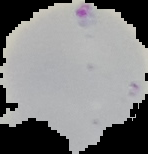

In [18]:
print('Example of a Parasitized image')
Image(path+'Parasitized/'+files_parasitized[0])

### Example image without Malaria

Example of an Uninfected image


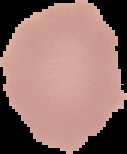

In [19]:
print('Example of an Uninfected image')
Image(path+'Uninfected/'+files_uninfected[0])

## Feature Engineering

### Normalizing the data set

In [0]:
X = np.array(X_raw)/255
y = np.array(y_raw)

## Train, Val, and Test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X validation shape:', X_val.shape)
print('y validation shape:', y_val.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X train shape: (1918, 115, 115, 3)
y train shape: (1918,)
X validation shape: (240, 115, 115, 3)
y validation shape: (240,)
X test shape: (240, 115, 115, 3)
y test shape: (240,)


In [0]:
def convnet(epochs, lr, batch, architecture, x_model, y_model, x_val, y_val):
  
  callbacks = [EarlyStopping(monitor='val_loss', patience=10),
               ModelCheckpoint(('/content/drive/My Drive/2019/Galileo/3er Trimestre/Deep Learning/Convnet/model/weights_checkpoints.h5'), 
                               save_best_only=True, 
                               save_weights_only=False)]
  
  #Defining the model
  model = Sequential()
  
  #Architecture
  for i in range(len(architecture['layers'])):
    if i == len(architecture['layers']):
      model.add(
        Conv2D(
            filters = architecture['layers'][i], 
            kernel_size = architecture['kernel_size'][i], 
            activation = architecture['activation'][i]
        )
      )
    else:
      model.add(
          Conv2D(
              filters = architecture['layers'][i], 
              kernel_size = architecture['kernel_size'][i], 
              activation = architecture['activation'][i],
              input_shape = (x_model.shape[1], x_model.shape[2], x_model.shape[3])
          )
      )
    model.add(
        MaxPooling2D(
            pool_size = (2,2)
        )
    )
  model.add(Flatten())
  model.add(Dense(128, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation = 'sigmoid'))
  #opt = Adam(lr=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])
  model.summary()
  
  #Training the model
  history = model.fit(
      x_model, 
      y_model, 
      epochs=epochs, 
      batch_size=batch, 
      validation_data=(x_val, y_val), 
      callbacks=callbacks, 
      verbose=2, 
      shuffle=False
  )
  
  return(model, history)

In [0]:
arch = {
    'layers': [32,64,64],
    'kernel_size': [3,3,3],
    'activation': ['relu', 'relu', 'relu']
}

In [24]:
m, h = convnet(
    epochs = 30,
    lr = 0.0001,
    batch = 64,
    architecture = arch,
    x_model = X_train,
    y_model = y_train,
    x_val = X_val,
    y_val = y_val
)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 113, 113, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 54, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        36928     
____________________________________

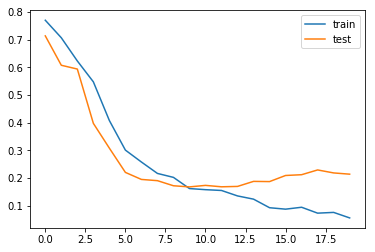

In [25]:
plt.plot(h.history['loss'], label='train')
plt.plot(h.history['val_loss'], label='test')
plt.legend()

As we can see, we have an accuracy of 95.83% over the validation dataset, which is very high. This was because of **early stopping**, started in iteration #11 with a patience of 10 iterations

## Results

In [26]:
res = pd.DataFrame()
res['y'] = y_test
res['Predicted'] = m.predict_classes(X_test)

print('Accuracy for Test Set: ', round(accuracy_score(y_test, m.predict_classes(X_test))*100, 2), '%', sep = "")

Accuracy for Test Set: 92.5%


### Results for a random test image

Test image shape #15: (115, 115, 3)


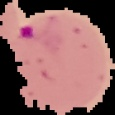

In [48]:
ind = np.random.randint(0,X_test.shape[0],1)[0]
rand_image = X_test[ind]
print('Test image shape #', ind,': ', rand_image.shape, sep = '')
cv2.imwrite('/content/drive/My Drive/2019/Galileo/3er Trimestre/Deep Learning/Convnet/rand_img.jpg', rand_image*255)
Image('/content/drive/My Drive/2019/Galileo/3er Trimestre/Deep Learning/Convnet/rand_img.jpg')

In [50]:
if m.predict_classes(rand_image.reshape((1,115,115,3)))[0]==0:
  print('Image #', ind, " doesn't have Malaria", sep = '')
else:
  print('Image #', ind, ' has Malaria', sep = '')

Image #15 has Malaria


## Annex

### Hidden Representations and Results

In [0]:
layer_outputs = [layer.output for layer in m.layers[:10]]
activation_model = Model(inputs=m.input, outputs=layer_outputs)

In [0]:
activation_model

In [0]:
def hidden(act, layer):
  hidden_layer = act[layer]
  channels = hidden_layer.shape[3]
  print(channels)
  print('Hidden layer', layer, 'representation')
  for i in range(channels):
    plt.matshow(hidden_layer[0, :, :, i], cmap='viridis')
  plt.close()

Original image shape: (115, 115, 3)
Original Image


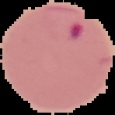

In [0]:
img = X_test[123]
img = cv2.resize(img, (115,115))
activations = activation_model.predict(img.reshape(1,115,115,3))
print('Original image shape:', img.shape)
cv2.imwrite('/content/drive/My Drive/2019/Galileo/3er Trimestre/Deep Learning/Convnet/test.jpg', img*255)
print('Original Image')
Image('/content/drive/My Drive/2019/Galileo/3er Trimestre/Deep Learning/Convnet/test.jpg')

### Hidden Layer #0 Representation with test image

32
Hidden layer 0 representation


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


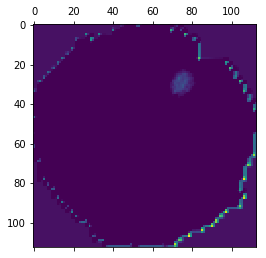

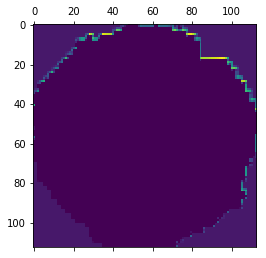

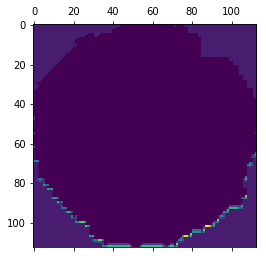

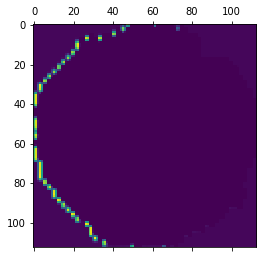

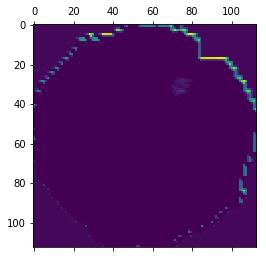

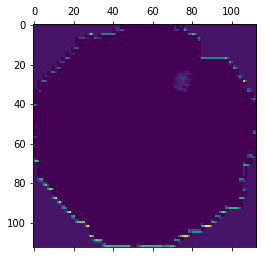

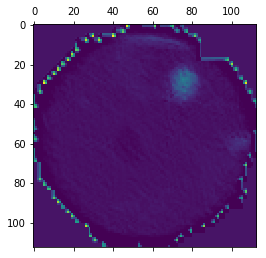

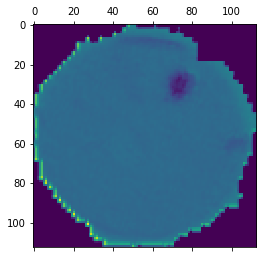

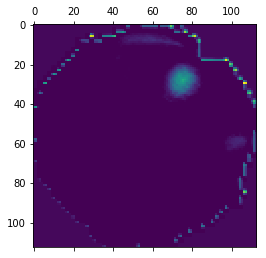

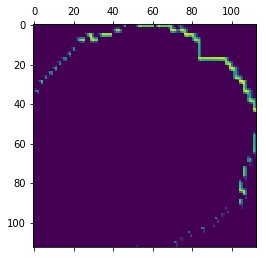

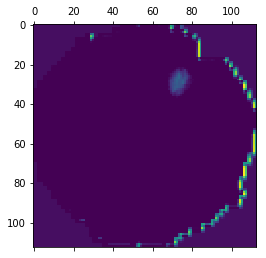

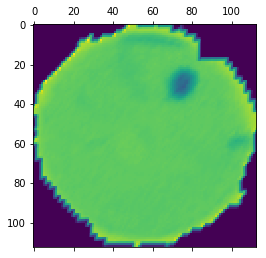

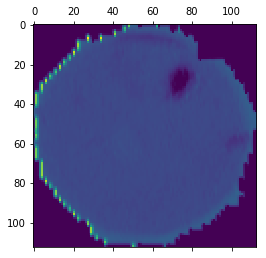

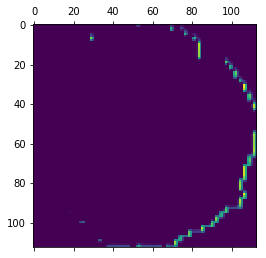

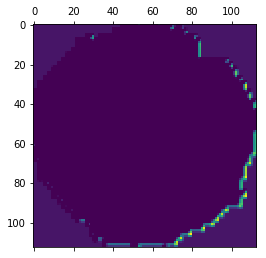

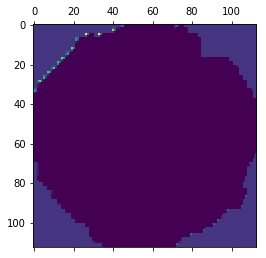

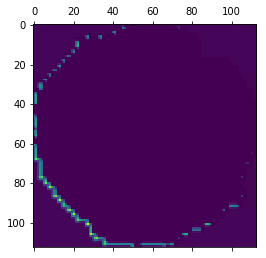

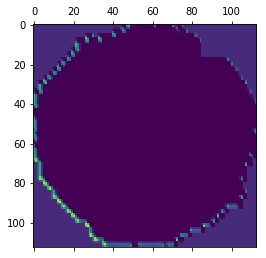

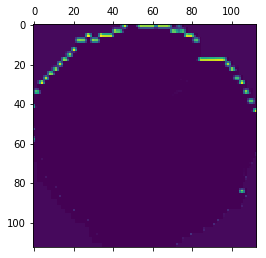

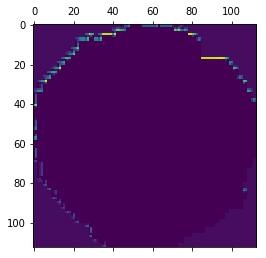

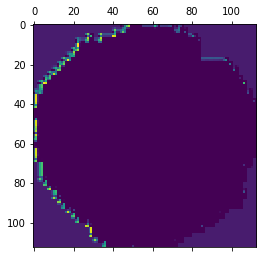

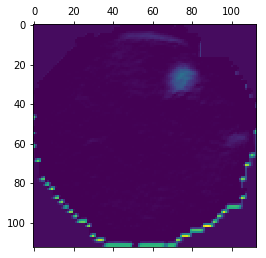

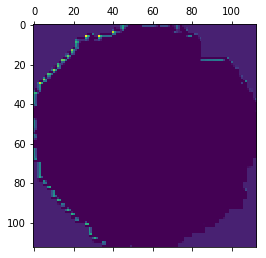

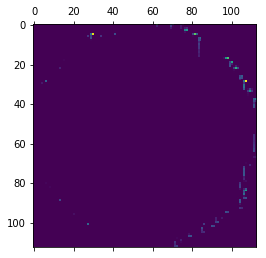

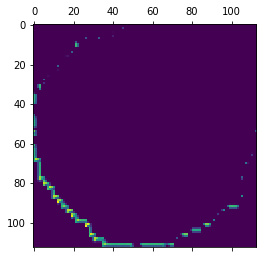

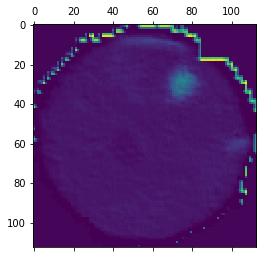

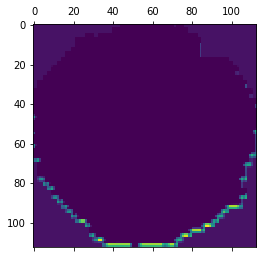

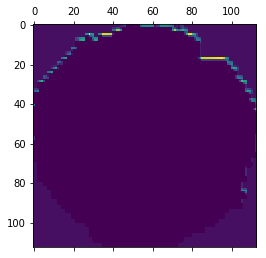

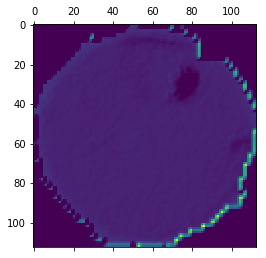

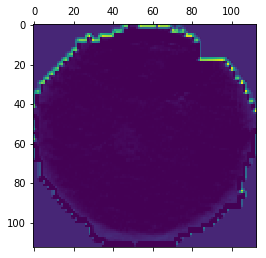

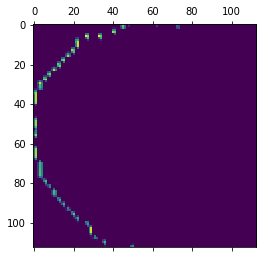

In [0]:
hidden(activations, 0)

### Filter representation for layer #0

In [0]:
filters, weights = m.layers[0].get_weights()

In [0]:
#Normalizing the filter
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

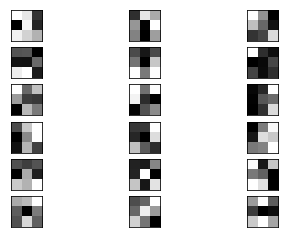

In [0]:
n = 6
k = 1
for i in range(n):
	forFilter = filters[:, :, :, i]
	for j in range(3):
		ax = plt.subplot(n, 3, k)
		ax.set_xticks([])
		ax.set_yticks([])
		plt.imshow(forFilter[:, :, j], cmap='gray')
		k += 1